In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/edu-data")
!ls

df_video_with_country_nonan.csv     stem_video_titles_tags_0.xlsx
final_keywords.txt		    stem_video_titles_tags_30percent.xlsx
is_stem_column_0.csv		    stem_video_titles_tags_50.xlsx
is_stem_column_30percent.csv	    video_with_channelcountry.csv
keyword_counts.txt		    video_with_channelcountry.csv.zip
__MACOSX			    video_with_country_and_stem.csv
no_econ_no_game_final_keywords.txt  video_with_stem_titles_and_cutoffs20.csv


In [3]:
import csv
import re

import numpy as np
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Educational Content: Indian vs The World

Are Indian people devoted into making educational videos?

In [111]:
df_channel_edu = pd.read_csv('education_channel_with_country.csv')
df_channel_other = pd.read_csv('other_channel_with_country.csv')

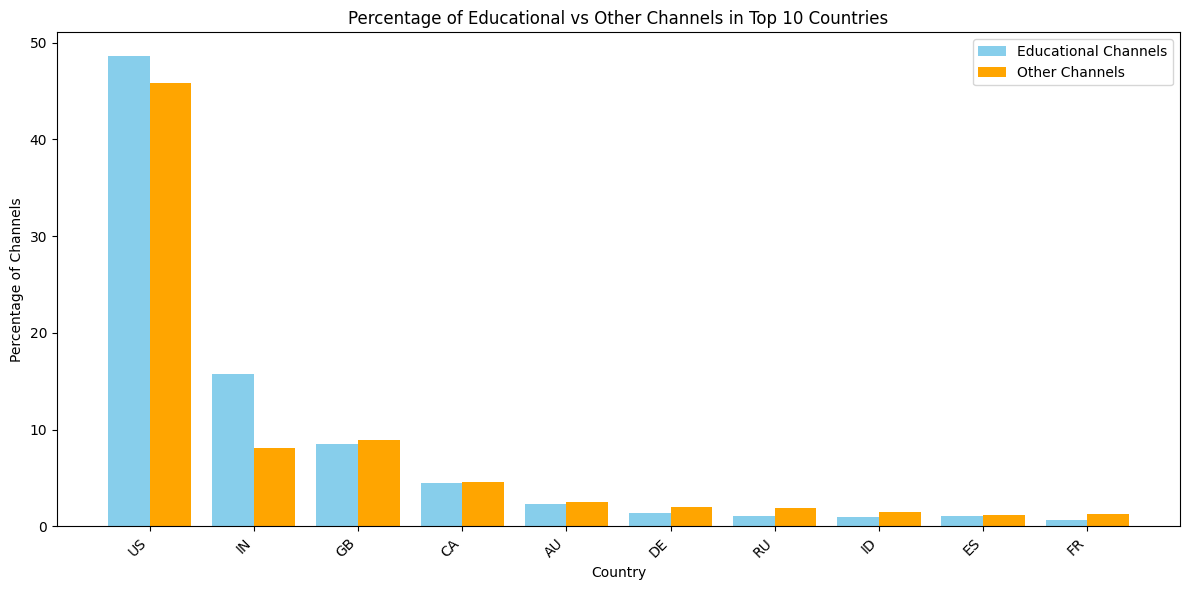

In [112]:
# Calculate the percentage of educational channels and other channels for each country
edu_country_counts = df_channel_edu['country'].value_counts(normalize=True) * 100
other_country_counts = df_channel_other['country'].value_counts(normalize=True) * 100

# Find the top 10 countries based on total percentage
total_counts = edu_country_counts.add(other_country_counts, fill_value=0)
top_10_countries = total_counts.nlargest(10).index

# Create data for the plot
edu_percentages = []
other_percentages = []

for country in top_10_countries:
    edu_percentage = edu_country_counts.get(country, 0)
    other_percentage = other_country_counts.get(country, 0)

    edu_percentages.append(edu_percentage)
    other_percentages.append(other_percentage)

# Create the bar chart with side-by-side bars
data = {'country': top_10_countries, 'edu_percentage': edu_percentages, 'other_percentage': other_percentages}
df_plot = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

x = range(len(top_10_countries))
width = 0.4

plt.bar([i - width/2 for i in x], df_plot['edu_percentage'], width=width, label='Educational Channels', color='skyblue')
plt.bar([i + width/2 for i in x], df_plot['other_percentage'], width=width, label='Other Channels', color='orange')

plt.xlabel('Country')
plt.ylabel('Percentage of Channels')
plt.title('Percentage of Educational vs Other Channels in Top 10 Countries')
plt.xticks(x, top_10_countries, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

The US and most other countries show minimal differences in the distribution between education and other categories. However, India stands out with a notably higher proportion of education channels compared to other types.

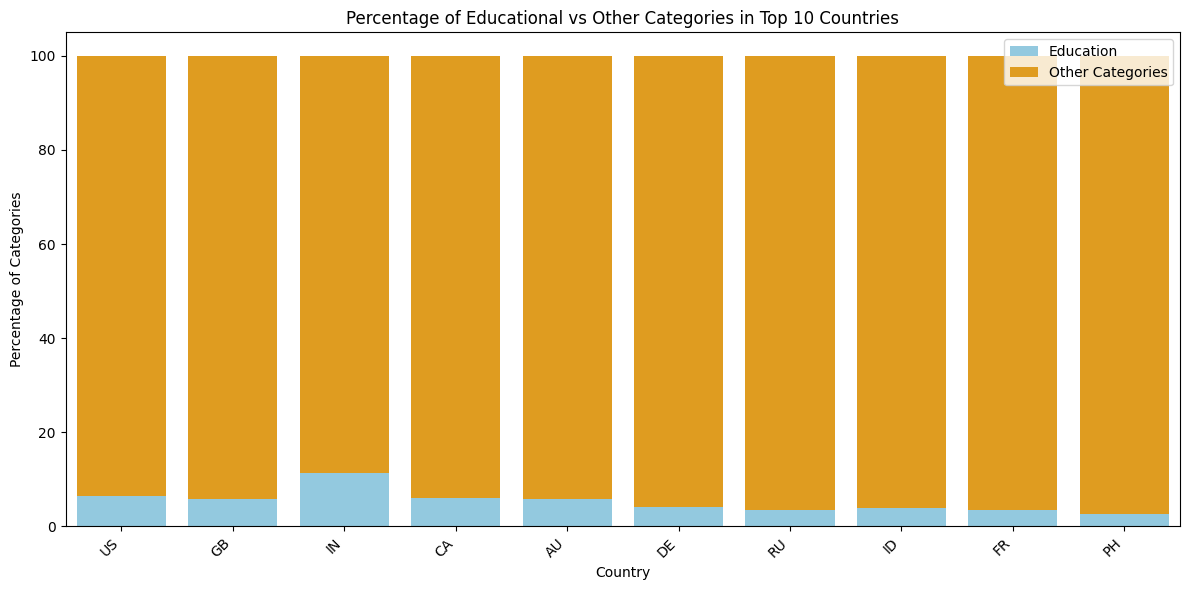

In [113]:
# Calculate the percentage of educational channels and other channels for each country
edu_country_counts = df_channel_edu['country'].value_counts()
other_country_counts = df_channel_other['country'].value_counts()

# Find the top 10 countries based on total percentage
total_counts = edu_country_counts.add(other_country_counts, fill_value=0)
top_10_countries = total_counts.nlargest(10).index

# Create data for the plot
edu_percentages = []
other_percentages = []

for country in top_10_countries:
    edu_count = edu_country_counts.get(country, 0)
    other_count = other_country_counts.get(country, 0)
    total_count = edu_count + other_count

    if total_count > 0:
        edu_percentage = (edu_count / total_count) * 100
        other_percentage = (other_count / total_count) * 100
    else:
        edu_percentage = 0
        other_percentage = 0

    edu_percentages.append(edu_percentage)
    other_percentages.append(other_percentage)

# Create the stacked bar chart
data = {'country': top_10_countries, 'edu_percentage': edu_percentages, 'other_percentage': other_percentages}
df_plot = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='edu_percentage', data=df_plot, color='skyblue', label='Education')
sns.barplot(x='country', y='other_percentage', data=df_plot, color='orange', label='Other Categories', bottom=df_plot['edu_percentage'])

plt.xlabel('Country')
plt.ylabel('Percentage of Categories')
plt.title('Percentage of Educational vs Other Categories in Top 10 Countries')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

The figure shows the top 10 countries based on percentage of all channel counts.
India (IN) has a higher percentage of educational content compared to other countries even though.

## Many people say... When studying STEM, no matter how hard or how strange a subject is, there's always an Indian Tutor on YouTube to help us pass our exams. Really?

# Let's work on the video data, and we can try to categorize the STEM content...

In [11]:
# Load STEM-categorized video data
df_video = pl.read_csv('/content/drive/MyDrive/edu-data/video_with_stem_titles_and_cutoffs20.csv')

In [51]:
len(df_video)

1911894

In [79]:
stem_videos = df_video.filter(pl.col("is_stem_cutoff_50") == 1)
len(stem_videos)

3057

In [80]:
stem_videos.sample(10)

categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,name_cc,subscribers_cc,country,is_stem_title,is_stem_cutoff_20,is_stem_cutoff_30,is_stem_cutoff_40,is_stem_cutoff_50
str,str,str,f64,str,i64,f64,str,str,str,f64,str,f64,str,bool,i64,i64,i64,i64
"""Education""","""UCsyZSg-iA7aN6C_jJ2hcLNw""","""2019-11-21 19:09:27.566112""",0.0,"""AQMTFKI19Tc""",390,2.0,"""genetics,drosophla melanogaste…","""gender specific inheritance ex…","""2018-09-20 00:00:00""",70.0,"""Nikolay's Genetics L...""",12149.0,"""US""",false,1,1,1,1
"""Education""","""UCsyZSg-iA7aN6C_jJ2hcLNw""","""2019-11-21 19:09:30.090854""",0.0,"""8D2Ha0_Tqbw""",580,5.0,"""inbreeding,genetics""","""how inbreeding works""","""2019-02-11 00:00:00""",116.0,"""Nikolay's Genetics L...""",12149.0,"""US""",false,1,1,1,1
"""Education""","""UCsyZSg-iA7aN6C_jJ2hcLNw""","""2019-11-21 19:09:21.670914""",0.0,"""M9lW9K_VKuQ""",239,2.0,"""population genetics,statistics""","""statistical methods applied to…","""2019-02-23 00:00:00""",103.0,"""Nikolay's Genetics L...""",12149.0,"""US""",false,1,1,1,1
"""Education""","""UCbRaUB7Hfe3clmKqqj8Nm1Q""","""2019-11-11 17:05:17.317205""",0.0,"""wNqYKabSc5o""",384,17.0,"""comfort,limits""","""re question of the week""","""2012-07-12 00:00:00""",435.0,"""laoshu505000""",769000.0,"""US""",false,1,1,1,1
"""Education""","""UCEBb1b_L6zDS3xTUrIALZOw""","""2019-11-08 18:48:20.739273""",0.0,"""mnvYIEbJXlM""",1098,24.0,"""time delay,resonances""","""l19.1 time delay and resonance…","""2017-07-05 00:00:00""",2369.0,"""MIT OpenCourseWare""",2.084328e6,"""US""",false,1,1,1,1
"""Education""","""UCABe2FgVNv2hgBeMu2mySVg""","""2019-11-13 14:05:16.198269""",39.0,"""2TAjS6Srr4A""",374,615.0,"""regular expression,language,co…","""what are regular expressions a…","""2014-05-27 00:00:00""",91656.0,"""Unacademy Studios - ...""",3.6e6,"""IN""",false,1,1,1,1
"""Education""","""UC5mq4Ywd0lPPQJnK_5gq-yA""","""2019-11-16 22:55:02.222200""",3.0,"""LHR7U32Xw0c""",541,93.0,"""calculus,limits,derivatives,in…","""product rule - derivatives - c…","""2010-12-30 00:00:00""",23062.0,"""Math Meeting""",381000.0,"""US""",false,1,1,1,1
"""Education""","""UC85BaVmStZexddgDR2vmqTQ""","""2019-11-23 03:30:37.850177""",12.0,"""ZZ3N0QSS9dY""",2865,203.0,"""physics,pradeep kshetrapal""","""xii-8.2.wave superposition, gr…","""2014-10-08 00:00:00""",38243.0,"""Pradeep Kshetrapal""",733000.0,"""IN""",false,1,1,1,1
"""Education""","""UC85BaVmStZexddgDR2vmqTQ""","""2019-11-23 03:29:35.571568""",128.0,"""WO_lQw-Jybs""",5152,2833.0,"""physics,pradeep kshetrapal""","""xii-9-1 ray optics reflection-…","""2015-09-07 00:00:00""",266984.0,"""Pradeep Kshetrapal""",733000.0,"""IN""",false,1,1,1,1


<ipython-input-81-19f3b9c29874>:4: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  country_counts = df_video.group_by("country").count().sort("count", descending=True)
<ipython-input-81-19f3b9c29874>:12: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  stem_country_counts = stem_videos.group_by("country").count().sort("count", descending=True)


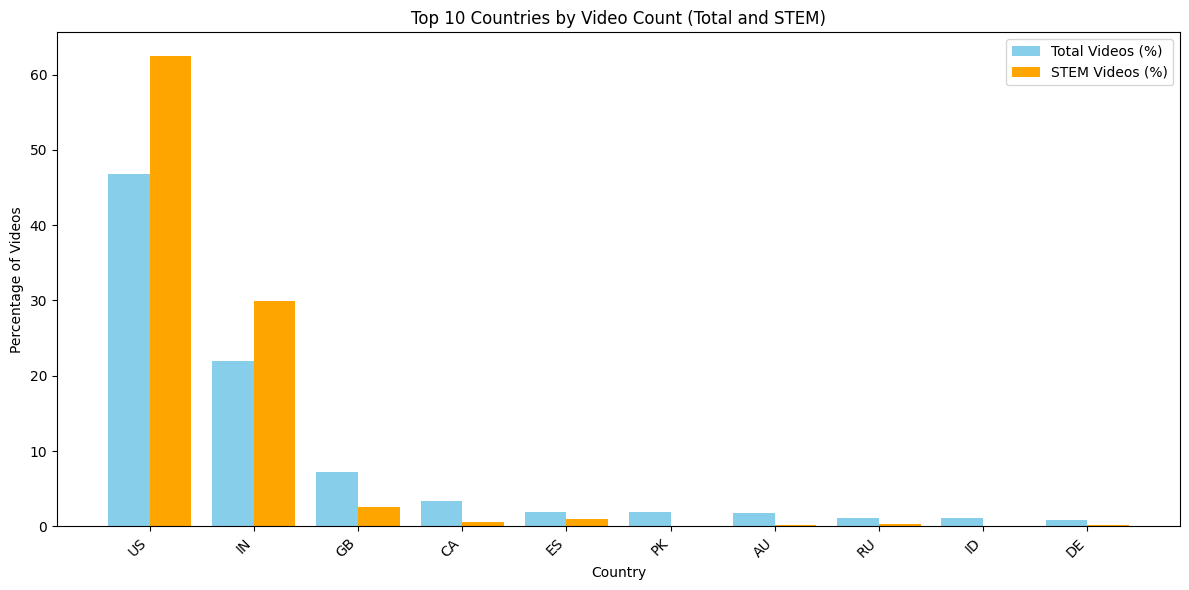

In [81]:
# Group by country and count videos
country_counts = df_video.group_by("country").count().sort("count", descending=True)

# Get the top 10 countries
top_10_countries = country_counts.limit(10).to_pandas()

# Calculate relative percentages
top_10_countries["total_percentage"] = (top_10_countries["count"] / len(df_video)) * 100

stem_country_counts = stem_videos.group_by("country").count().sort("count", descending=True)

# Merge dataframes
top_10_countries = pd.merge(top_10_countries, stem_country_counts.to_pandas(), on="country", how="left", suffixes=("_total","_stem"))
top_10_countries["stem_percentage"] = (top_10_countries["count_stem"] / len(stem_videos)) * 100
top_10_countries.fillna(0, inplace=True)


# Plotting
plt.figure(figsize=(12, 6))

bar_width = 0.4

# Total Video Percentage
plt.bar(np.arange(len(top_10_countries)), top_10_countries["total_percentage"], width=bar_width, label="Total Videos (%)", color='skyblue')

# STEM Video Percentage
plt.bar(np.arange(len(top_10_countries)) + bar_width, top_10_countries["stem_percentage"], width=bar_width, label="STEM Videos (%)", color='orange')


plt.xlabel("Country")
plt.ylabel("Percentage of Videos")
plt.title("Top 10 Countries by Video Count (Total and STEM)")
plt.xticks(np.arange(len(top_10_countries)) + bar_width / 2, top_10_countries["country"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

From the above graph, it seems like the US and India has the significance of STEM Videos percentage compared to others. Let's take a deeper look into this:

In [83]:
# Convert the 'upload_date' column to datetime objects
stem_videos = stem_videos.with_columns(pl.col("upload_date").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))

# Extract the year from the 'upload_date'
stem_videos = stem_videos.with_columns(pl.col("upload_date").dt.year().alias("upload_year"))

<ipython-input-109-0f871f4eab8f>:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("video_count"),


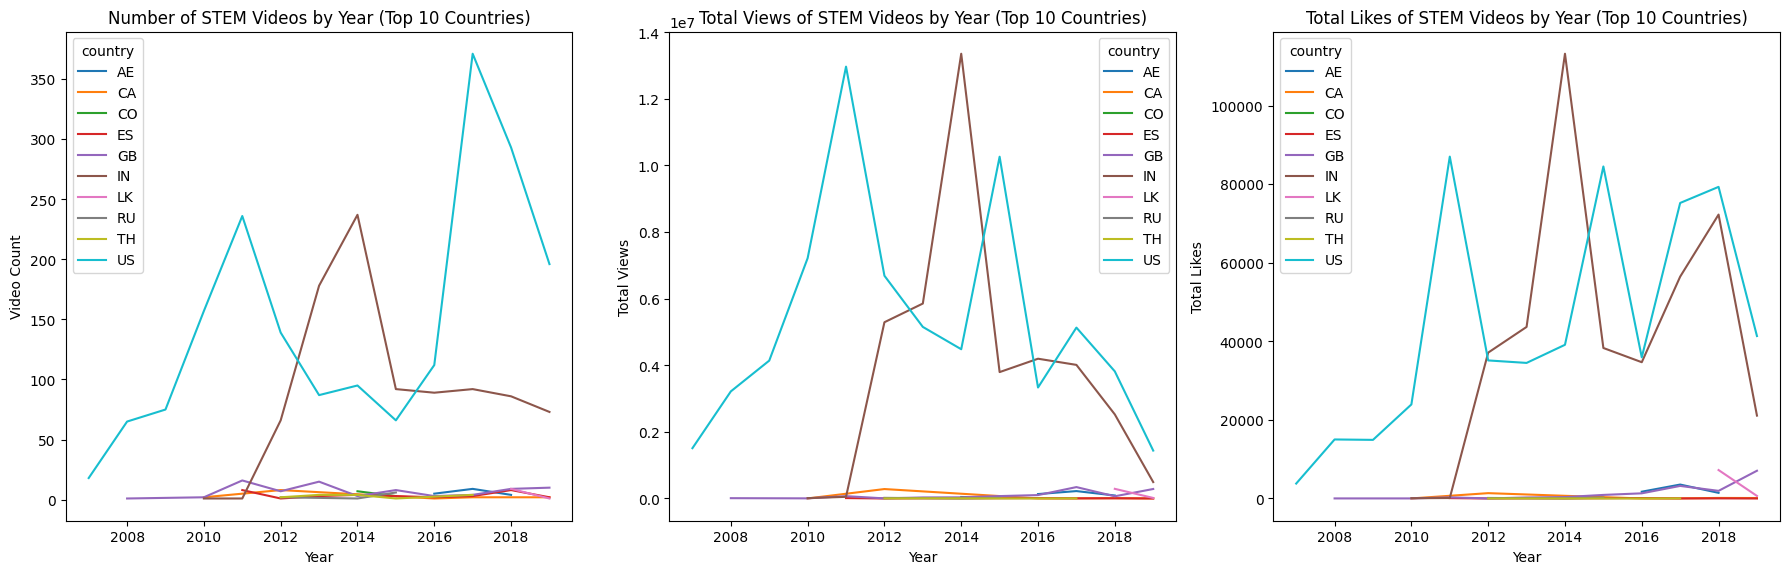

In [109]:
# Group data by country and year
grouped_data = stem_videos.group_by(["country", "upload_year"]).agg(
    [
        pl.count().alias("video_count"),
        pl.sum("view_count").alias("total_views"),
        pl.sum("like_count").alias("total_likes"),
    ]
)

# Get the top 10 countries with the most STEM videos
top_10_countries = stem_country_counts.sort("count", descending=True).head(10)
top_10_countries_list = top_10_countries["country"].to_list()

# Filter data for the top 10 countries
top_10_data = grouped_data.filter(pl.col("country").is_in(top_10_countries_list))

# Convert to pandas for plotting
top_10_df = top_10_data.to_pandas()

# Plotting
plt.figure(figsize=(18, 6))

# Setting the hue order
sorted_countries = sorted(top_10_growth_df['country'].unique())

# Video count
plt.subplot(1, 3, 1)
sns.lineplot(x="upload_year", y="video_count", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Number of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Video Count")


# View count
plt.subplot(1, 3, 2)
sns.lineplot(x="upload_year", y="total_views", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Total Views of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Total Views")


# Like count
plt.subplot(1, 3, 3)
sns.lineplot(x="upload_year", y="total_likes", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Total Likes of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Total Likes")


plt.tight_layout()
plt.show()

Not just percentage-wise, temporal-wise, it seems like the US and India has long been "competitor" in STEM content creation! And we can also observe how US started the "trend" first, with its peak happen at around 2011 while that of India started somewhere in 2014. Interestingly, by 2019, we can see that the number of videos of US is significantly higher, however the difference in their view and like count is much more negligible. So even though Indians might still catching up with the quantity, its quality has already reached similar level as its competitor!

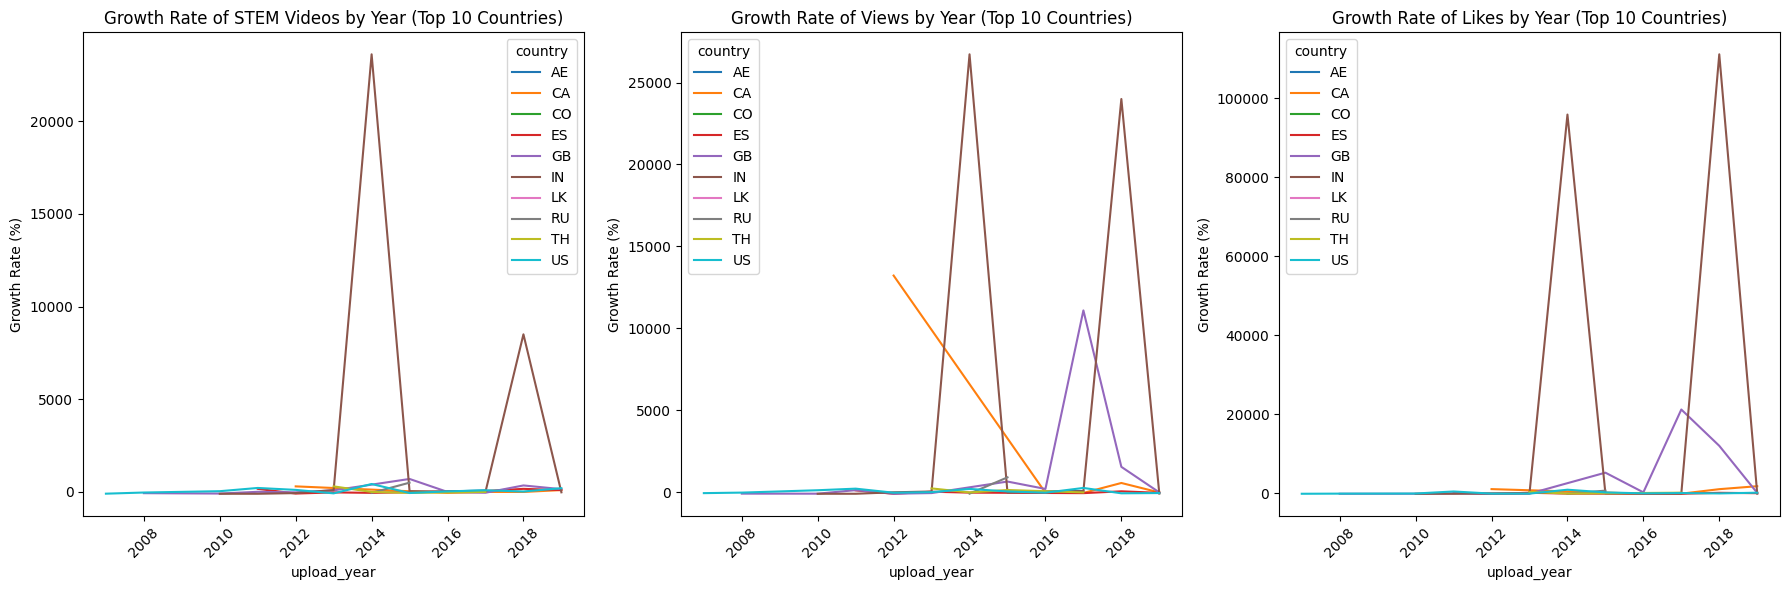

In [110]:
# Calculate year-over-year percentage change
def calculate_growth_rate(df, group_by, column, new_column_name):
    df_sorted = df.sort_values([group_by, 'upload_year'])
    df[new_column_name] = df.groupby(group_by)[column].pct_change() * 100
    return df

# Create a copy to avoid overwriting the original dataframe
top_10_growth_df = top_10_df.copy()

# Apply the function to calculate growth rates
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'video_count', 'video_growth_rate')
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'total_views', 'views_growth_rate')
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'total_likes', 'likes_growth_rate')

# Plotting
plt.figure(figsize=(18, 6))

# Number of videos growth rate
plt.subplot(1, 3, 1)
sns.lineplot(x="upload_year", y="video_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of STEM Videos by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

# Total views growth rate
plt.subplot(1, 3, 2)
sns.lineplot(x="upload_year", y="views_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of Views by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

# Total likes growth rate
plt.subplot(1, 3, 3)
sns.lineplot(x="upload_year", y="likes_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of Likes by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

plt.tight_layout()
plt.show()


Even in terms of growth rate, we can observe significant peaks for Indians whereas the growth for US seems much more "stable".

TODO: MORE TEXT ON HOW THE TREND IS INTERESTING.

# Yes, now we know Indian loves making educational videos to share their knowledge, especially in STEM content, but are they popular? Do they receive more likes?
We can compare between US and India because they are both english speaking and have similar share of STEM videos on YouTube.

In [120]:
# Convert df_channel_edu to a polars DataFrame
df_channel_edu_pl = pl.from_pandas(df_channel_edu)

# Rename the 'channel' column to 'channel_id' in df_channel_edu_pl
df_channel_edu_pl = df_channel_edu_pl.rename({"channel": "channel_id"})

# Filter stem_videos for IN and US separately
stem_videos_in = stem_videos.filter(pl.col("country") == "IN")
stem_videos_us = stem_videos.filter(pl.col("country") == "US")

# Join with df_channel_edu_pl for IN and select desired columns
merged_df_in = stem_videos_in.join(df_channel_edu_pl, on="channel_id", how="inner")
merged_df_in = merged_df_in.unique(subset=["channel_id"])  # Make channel_id unique
merged_df_in = merged_df_in.select(df_channel_edu_pl.columns) # Select only columns from df_channel_edu_pl

# Join with df_channel_edu_pl for US and select desired columns
merged_df_us = stem_videos_us.join(df_channel_edu_pl, on="channel_id", how="inner")
merged_df_us = merged_df_us.unique(subset=["channel_id"])  # Make channel_id unique
merged_df_us = merged_df_us.select(df_channel_edu_pl.columns) # Select only columns from df_channel_edu_pl

# Now you have two separate DataFrames with unique channel_ids and desired columns:
# merged_df_in: Contains channel data for India
# merged_df_us: Contains channel data for US

# Display the DataFrames (optional)
print("Channel data for India:")
print(merged_df_in)

print("\nChannel data for US:")
print(merged_df_us)

Channel data for India:
shape: (38, 8)
┌────────────┬────────────┬────────────┬────────────┬────────────┬───────────┬───────────┬─────────┐
│ category_c ┆ join_date  ┆ channel_id ┆ name_cc    ┆ subscriber ┆ videos_cc ┆ subscribe ┆ country │
│ c          ┆ ---        ┆ ---        ┆ ---        ┆ s_cc       ┆ ---       ┆ r_rank_sb ┆ ---     │
│ ---        ┆ str        ┆ str        ┆ str        ┆ ---        ┆ i64       ┆ ---       ┆ str     │
│ str        ┆            ┆            ┆            ┆ f64        ┆           ┆ f64       ┆         │
╞════════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╪═════════╡
│ Education  ┆ 2017-06-20 ┆ UCdeB-0UW- ┆ I'm Azad   ┆ 178000.0   ┆ 52        ┆ 98940.0   ┆ IN      │
│            ┆            ┆ 8RNOdq821H ┆            ┆            ┆           ┆           ┆         │
│            ┆            ┆ nr6w       ┆            ┆            ┆           ┆           ┆         │
│ Education  ┆ 2015-04-08 ┆ UCCUr096WD ┆ Vidya-mitr 

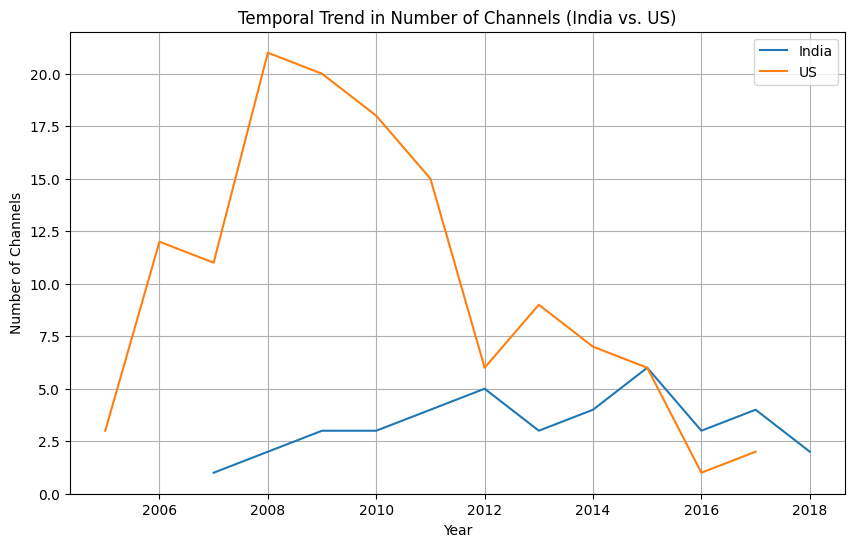

In [137]:
# Group data by year and count channels
channel_trend_in = merged_df_in.groupby('join_year')['channel_id'].count().reset_index()
channel_trend_us = merged_df_us.groupby('join_year')['channel_id'].count().reset_index()


# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='join_year', y='channel_id', data=channel_trend_in, label='India')
sns.lineplot(x='join_year', y='channel_id', data=channel_trend_us, label='US')
plt.xlabel('Year')
plt.ylabel('Number of Channels')
plt.title('Temporal Trend in Number of Channels (India vs. US)')
plt.legend()
plt.grid(True)
plt.show()

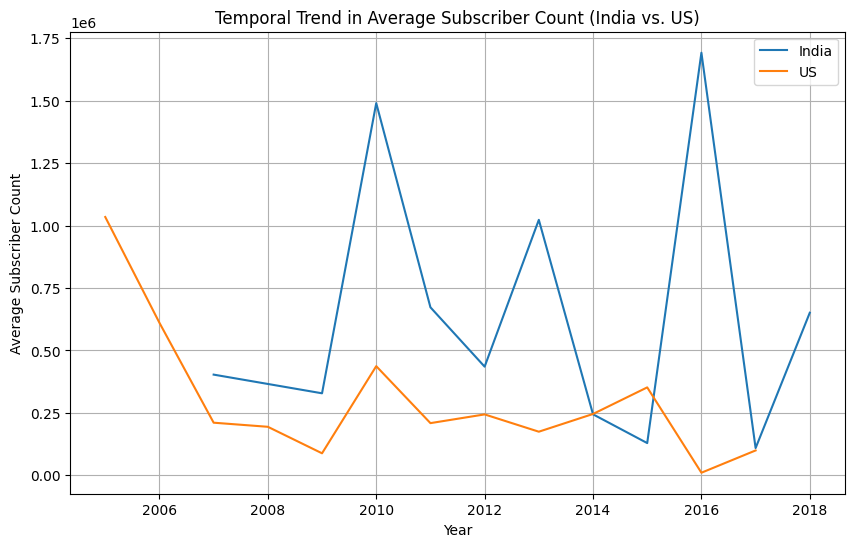

In [134]:
# Function to extract year from upload date
def extract_year(df):
    # Convert to Polars DataFrame if it's a pandas DataFrame
    if isinstance(df, pd.DataFrame):
        df = pl.from_pandas(df)

    # Directly cast to pl.Int64 and alias as 'join_year'
    df = df.with_columns(pl.col("join_date").cast(pl.Int64).alias("join_year"))
    return df

# Convert subscribers_cc to numeric, coercing errors to NaN
# Using with_columns for Polars DataFrames
# Convert to Polars DataFrame if it's a pandas DataFrame
if isinstance(merged_df_in, pd.DataFrame):
    merged_df_in = pl.from_pandas(merged_df_in)
if isinstance(merged_df_us, pd.DataFrame):
    merged_df_us = pl.from_pandas(merged_df_us)

merged_df_in = merged_df_in.with_columns(pl.col("subscribers_cc").cast(pl.Float64)) # Convert to Float64 for numerical operations
merged_df_us = merged_df_us.with_columns(pl.col("subscribers_cc").cast(pl.Float64))

# Extract year from upload_date and handle potential errors
merged_df_in = extract_year(merged_df_in) # No need to convert to pandas here
merged_df_us = extract_year(merged_df_us)

# Convert to pandas for plotting with seaborn
# moved these lines after all polars operations
merged_df_in = merged_df_in.to_pandas()
merged_df_us = merged_df_us.to_pandas()

# Group by year and calculate mean subscriber count
subscriber_trend_in = merged_df_in.groupby('join_year')['subscribers_cc'].mean().reset_index()
subscriber_trend_us = merged_df_us.groupby('join_year')['subscribers_cc'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='join_year', y='subscribers_cc', data=subscriber_trend_in, label='India')
sns.lineplot(x='join_year', y='subscribers_cc', data=subscriber_trend_us, label='US')
plt.xlabel('Year')
plt.ylabel('Average Subscriber Count')
plt.title('Temporal Trend in Average Subscriber Count (India vs. US)')
plt.legend()
plt.grid(True)
plt.show()

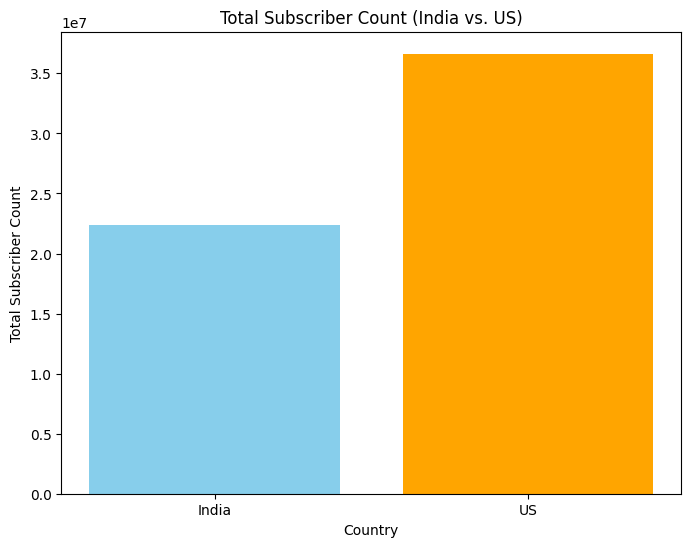

In [136]:
# Calculate total subscriber count for IN and US
total_subscribers_in = merged_df_in['subscribers_cc'].sum()
total_subscribers_us = merged_df_us['subscribers_cc'].sum()

# Create the bar chart
countries = ['India', 'US']
subscribers = [total_subscribers_in, total_subscribers_us]

plt.figure(figsize=(8, 6))
plt.bar(countries, subscribers, color=['skyblue', 'orange'])
plt.xlabel('Country')
plt.ylabel('Total Subscriber Count')
plt.title('Total Subscriber Count (India vs. US)')
plt.show()

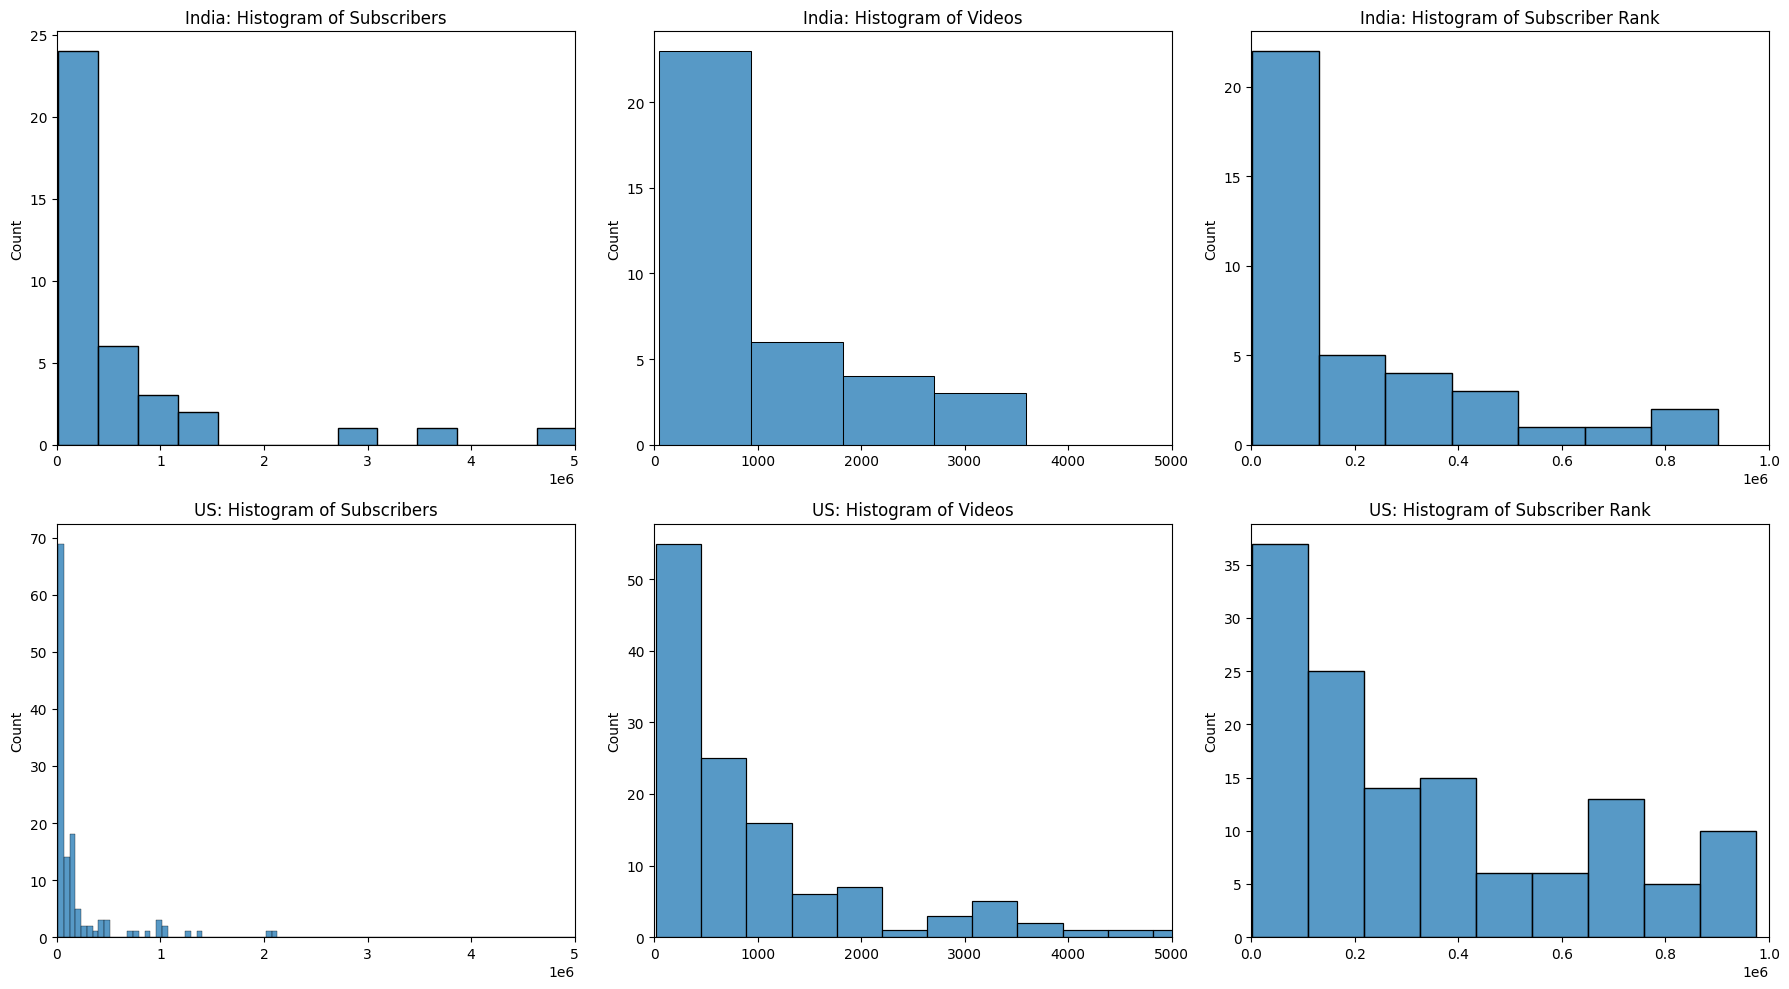

In [124]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# India: Plot for Subscribers with adjusted x-axis limit
sns.histplot(merged_df_in['subscribers_cc'], ax=axes[0, 0])
axes[0, 0].set_title('India: Histogram of Subscribers')
axes[0, 0].set_xlim(0, 5000000)

# India: Plot for Videos with adjusted x-axis limit
sns.histplot(merged_df_in['videos_cc'], ax=axes[0, 1])
axes[0, 1].set_title('India: Histogram of Videos')
axes[0, 1].set_xlim(0, 5000)

# India: Plot for Subscriber Rank with consistent x-axis limit
sns.histplot(merged_df_in['subscriber_rank_sb'], ax=axes[0, 2])
axes[0, 2].set_title('India: Histogram of Subscriber Rank')
axes[0, 2].set_xlim(0, 1000000)  # Set the limit for consistency

# US: Plot for Subscribers with adjusted x-axis limit
sns.histplot(merged_df_us['subscribers_cc'], ax=axes[1, 0])
axes[1, 0].set_title('US: Histogram of Subscribers')
axes[1, 0].set_xlim(0, 5000000)

# US: Plot for Videos with adjusted x-axis limit
sns.histplot(merged_df_us['videos_cc'], ax=axes[1, 1])
axes[1, 1].set_title('US: Histogram of Videos')
axes[1, 1].set_xlim(0, 5000)

# US: Plot for Subscriber Rank with consistent x-axis limit
sns.histplot(merged_df_us['subscriber_rank_sb'], ax=axes[1, 2])
axes[1, 2].set_title('US: Histogram of Subscriber Rank')
axes[1, 2].set_xlim(0, 1000000)  # Set the limit for consistency

plt.tight_layout()
plt.show()

TODO:
* Topic breakdown + example
* Engagement metrics?

Ideas:
* Correlational Analysis - what drives them to make vids - likes, views, ?
* Characteristics? e.g duration? consistent uploads??? other attributes - that might relate to their "success"
*